In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00


In [ ]:
import torch
import transformers as bert_trained
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import re

import nltk # работа с пакетами языков
from nltk import word_tokenize, ngrams # токенизация и деление на n граммы
from wordcloud import WordCloud # визуальное отображение
from nltk.corpus import stopwords # стопслова, extend
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv(f"IMDB_Dataset_new.csv",delimiter=",")
df.head()

,Unnamed: 0,review,sentiment
0,0,one of the other reviewers has mentioned that ...,1.0
1,1,a wonderful little production br br the filmin...,1.0
2,2,i thought this was a wonderful way to spend ti...,1.0
3,3,basically theres a family where a little boy j...,0.0
4,4,petter matteis love in the time of money is a ...,1.0


In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,Unnamed: 0,review,sentiment
0,0,one of the other reviewers has mentioned that ...,0
1,1,a wonderful little production br br the filmin...,0
2,2,i thought this was a wonderful way to spend ti...,0
3,3,basically theres a family where a little boy j...,0
4,4,petter matteis love in the time of money is a ...,0


In [ ]:
df.shape

(7429, 3)

In [ ]:
df.describe(include="all")

,Unnamed: 0,review,sentiment
count,7429.000000,7429,7428.000000
unique,NaN,7420,NaN
top,NaN,my favourite police series of all time turns t...,NaN
freq,NaN,2,NaN
mean,3714.000000,NaN,0.500135
std,2144.711908,NaN,0.500034
min,0.000000,NaN,0.000000
25%,1857.000000,NaN,0.000000
50%,3714.000000,NaN,1.000000
75%,5571.000000,NaN,1.000000


Text(0.5, 0, 'sentiments')

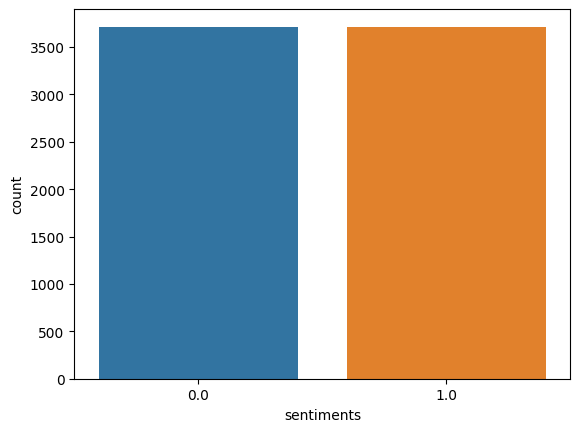

In [ ]:
sns.countplot(x=df['sentiment'])
plt.xlabel('sentiments')

In [ ]:
df['review'] = df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

df

,Unnamed: 0,review,sentiment
0,0,one of the other reviewers has mentioned that ...,1.0
1,1,a wonderful little production br br the filmin...,1.0
2,2,i thought this was a wonderful way to spend ti...,1.0
3,3,basically theres a family where a little boy j...,0.0
4,4,petter matteis love in the time of money is a ...,1.0
...,...,...,...
7424,7424,how good is this film apparently good enough t...,1.0
7425,7425,the movie was excellent save for some of the s...,1.0
7426,7426,it could be easy to complain about the quality...,1.0
7427,7427,this animated inspector gadget movie is pretty...,0.0


In [ ]:
df.to_csv("./IMDB_Dataset_new.csv")

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words.extend(['br'])

In [ ]:
from transformers import BertTokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = r'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [ ]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
short_df = df[:1000]

In [ ]:
RANDOM_SEED = 1234

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class IMDBClassifier(nn.Module):

  def __init__(self, n_classes):
    super(IMDBClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device( 'cpu'  )
device

device(type='cpu')

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM,BertModel

In [ ]:
model = IMDBClassifier(len(df['sentiment'].unique()))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 32])
torch.Size([16, 32])


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)

      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

TypeError: ignored

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

TypeError: ignored

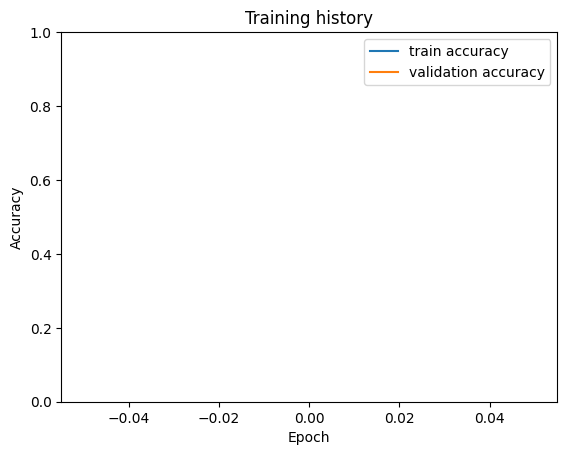

In [ ]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

In [ ]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: ignored

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

In [ ]:
short_df = df[:300]

In [ ]:
def clean_eng(x):
    return ' '.join([word for word in word_tokenize(x) if word not in stop_words])

In [ ]:
short_df['review'] = short_df['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [ ]:
short_df


In [ ]:
short_df['review'].value_counts()

In [ ]:
tokenized_df = short_df['review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True)))

In [ ]:
tokenized_df

In [ ]:
max_len = max([len(sent) for sent in tokenized_df])
print('Max length: ', max_len)

In [ ]:
short_df.dtypes

In [ ]:
short_df['tokenized_review'] = tokenized_df

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val =\
    train_test_split(short_df['tokenized_review'], short_df['sentiment'], test_size=0.1, random_state=2020)

In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)